# ALS BL5.3.1 Commissioning using bluesky

awojdyla@lbl.gov francisho@lbl.gov - June 2025

We are commissionning the beamlines using EPICS/bluesky after prolonged dark time.

We want to:
+ perform bluesky scan for simple diode
+ Perform energy scan to evaluate the effects of the cryo cooler on the mono. 
+ Evaluate the photon energy resolution of the BL. 
+ perform scanning imaging

In [6]:
import epics
import bluesky
import numpy as np
#import matplotlib.pyplot as plt
#import time 

In [2]:
from bluesky import RunEngine
RE = RunEngine({})

In [3]:
from databroker import Broker
db = Broker.named('temp')

# Insert all metadata/data captured into db.
RE.subscribe(db.insert)

0

### Connecting to EPICS motors
We had some issues here witht the picoscale interformeter -- we need to use caproto to talk to it (ophyd's motor does not work directly out of the box)

from: https://nsls-ii.github.io/bluesky/tutorial.html

```
from ophyd import EpicsMotor
nano_top_x = EpicsMotor('XF:31ID-ES{Dif:Nano-Ax:TopX}Mtr', name='nano_top_x')
```
see also:

https://blueskyproject.io/ophyd/generated/ophyd.epics_motor.EpicsMotor.html#:~:text=class%20ophyd.epics_motor.EpicsMotor%28prefix%3D%27%27%2C%20%2A%2C%20name%2C%20kind%3DNone%2C%20read_attrs%3DNone%2C%20configuration_attrs%3DNone%2C%20parent%3DNone%2C,are%20passed%20through%20to%20the%20base%20class%2C%20Positioner




In [4]:
from ophyd import EpicsMotor
import ophyd
ophyd.set_cl('caproto')

mono_angle_deg = ophyd.EpicsMotor('bl531_xps1:mono_angle_deg', name='mono angle [deg]')
beamstop_diode = ophyd.EpicsSignal('bl201-beamstop:current', name='beamstop diode')

#this works
mono_angle_deg.wait_for_connection(timeout=2.0)
mono_angle_deg.read()
beamstop_diode.wait_for_connection(timeout=2.0)
beamstop_diode.read()

{'beamstop diode': {'value': -170.56, 'timestamp': 1750873698.763738}}

## Spectroscopic scan

In [ ]:
# define mono angle to energy conversion
# ****always run a reference material if you are doing anything involving energy variation
# # mrl 5/30/25 --> this conversion is off, Mn K-edge has shifted 10s of eVs

#physical constants
h_m2kgps = 6.6261e-34
c_mps    = 299792458   
e_eV     = 6.2415e+18
# Silicon spacing (for Bragg condition)
Si_m = 5.43E-10
a_Si111_m = Si_m/np.sqrt(1^2+1^2+1^2)
# Monochromotor offset
mono_offset_deg = 12.787
# Wavelength from energy
lambda_m = lambda E_eV : h_m2kgps*c_mps*e_eV/E_eV
# Bragg angle from Wavelength
bragg_deg = lambda E_eV: np.arcsin(lambda_m(E_eV)/(2*a_Si111_m))*180/np.pi
# Mono angle from Bragg angle
mono_deg = lambda E_eV: bragg_deg(E_eV)+mono_offset_deg

# inverse function to go from mono angle to eV
energy_eV = lambda mono_deg_input: (h_m2kgps*c_mps*e_eV)/((2 * a_Si111_m) * np.sin((np.pi/180)*(mono_deg_input - mono_offset_deg)))

In [19]:
from bluesky.plans import scan
E_eV_start = 8000 # start energy in eV
E_eV_stop = 10000 # start energy in eV

start = mono_deg(E_eV_start)
stop  = mono_deg(E_eV_stop)
N_e = 101


RE(scan([beamstop_diode], mono_angle_deg, start, stop,N_e))

('e9cfce29-4560-4004-9764-081b9e2cd627',)

In [ ]:
## this has crashed my motors -- be careful

# # some issues here -- not critical
# from bluesky.callbacks.best_effort import BestEffortCallback
# bec = BestEffortCallback()
# # Send all metadata/data captured to the BestEffortCallback.
# bec_token = RE.subscribe(bec)

#RE.unsubscribe(bec_token)

In [20]:
header = db[-1]
header.table()

,time,beamstop diode,mono angle [deg],mono angle [deg]_user_setpoint
seq_num,,,,
1,2025-06-25 18:00:31.463576317,-350.90,27.098,27.097538
2,2025-06-25 18:00:31.664891481,-350.90,27.069,27.068482
3,2025-06-25 18:00:31.875826836,-281.00,27.040,27.039426
4,2025-06-25 18:00:32.086730003,-281.00,27.010,27.010370
5,2025-06-25 18:00:32.279512167,-281.00,26.981,26.981314
...,...,...,...,...
97,2025-06-25 18:00:51.403544426,-170.22,24.308,24.308160
98,2025-06-25 18:00:51.606738329,-170.22,24.279,24.279104
99,2025-06-25 18:00:51.819824696,-170.22,24.250,24.250048


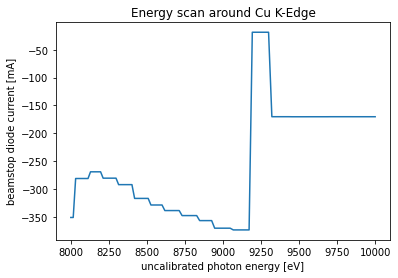

In [23]:
%matplotlib inline
a = header.table()
import matplotlib.pyplot as plt

t = a['mono angle [deg]'].to_numpy()

d = a['beamstop diode'].to_numpy()

plt.plot(energy_eV(t), d)
plt.title('Energy scan around Cu K-Edge, no cryocooling')
plt.xlabel('uncalibrated photon energy [eV]')
plt.ylabel('beamstop diode current [mA]')

plt.show()

Comments on the results:
+ Francis: the diode is reading too slow
+ this should be the copper edge, but it's shiftd by 200 eV (this probably has to do with how energy is calibratied)


In [31]:
from bluesky.plans import scan, list_scan
E_eV_start = 8000 # start energy in eV
E_eV_stop = 10000 # start energy in eV
N_e = 101  # number of energy points

Es_eV = np.linspace(E_eV_start, E_eV_stop, N_e)
thetas_deg = mono_deg(Es_eV)

mono_angle_deg.settle_time = 0.5

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg))


('fe7ba76b-3520-49c6-b87d-01fad6666066',)

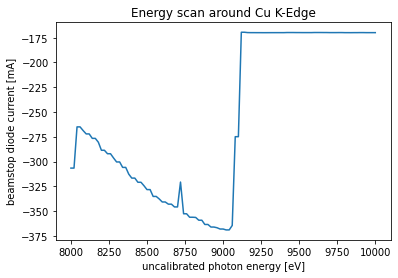

In [32]:
%matplotlib inline

a = db[-1].table()
import matplotlib.pyplot as plt

t = a['mono angle [deg]'].to_numpy()

d = a['beamstop diode'].to_numpy()

plt.plot(energy_eV(t), d)
plt.title('Energy scan around Cu K-Edge')
plt.xlabel('uncalibrated photon energy [eV]')
plt.ylabel('beamstop diode current [mA]')

plt.show()

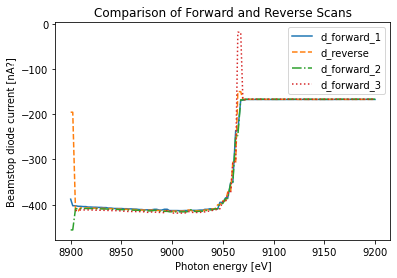

In [ ]:
plt.plot(energy_eV(t), d_forward_1, label='d_forward_1')
plt.plot(energy_eV(t), d_reverse, label='d_reverse', linestyle='--')
plt.plot(energy_eV(t), d_forward_2, label='d_forward_2', linestyle='-.')
plt.plot(energy_eV(t)[2:], d_forward_3[2:], label='d_forward_3', linestyle=':')
plt.title('Comparison of Forward and Reverse Scans')
plt.xlabel('Photon energy [eV]')
plt.ylabel('Beamstop diode current [nA?]')
plt.legend()
plt.show()

## Sample scan

In [37]:
mono_angle_deg = ophyd.EpicsMotor('bl531_xps1:mono_angle_deg', name='mono angle [deg]')
beamstop_diode = ophyd.EpicsSignal('bl201-beamstop:current', name='beamstop diode')
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

In [38]:
mono_angle_deg.move(25)

MoveStatus(done=True, pos=mono angle [deg], elapsed=1.1, success=True, settle_time=0.0)

In [45]:
from bluesky.plans import grid_scan

RE(grid_scan([beamstop_diode], sample_x_mm, 0, 20, 5, sample_y_mm, 0,20,5,snake_axes=True))

('9e5eeb39-0b49-4ec3-8ed9-8996979414f4',)

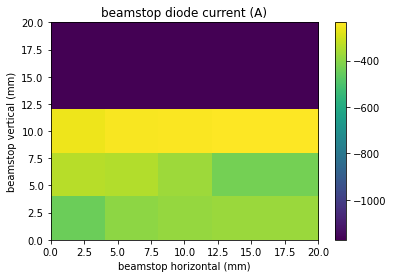

In [46]:
header = db[-1]
a = header.table()

# horizontal axis is reverted somehow (14,6 is optimal) 

h = a['sample stage horizontal'].to_numpy()
v = a['sample stage vertical'].to_numpy()
b = a['beamstop diode'].to_numpy()
b = b.reshape(5, 5)

plt.imshow(b, extent=(h.min(), h.max(), v.min(), v.max()), aspect='auto')
plt.xlabel('beamstop horizontal (mm)')
plt.ylabel('beamstop vertical (mm)')
plt.title('beamstop diode current (A)')
plt.colorbar()
plt.show()

In [52]:
from bluesky.plans import grid_scan

RE(grid_scan([beamstop_diode], sample_x_mm, 0, 20, 21, sample_y_mm, 0,20,21,snake_axes=True))

('f4f84bcc-488e-4b40-8f35-16d19bf4f5fb',)

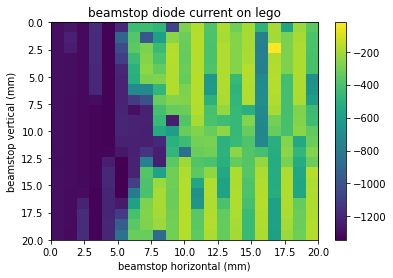

In [55]:
header = db[-1]
a = header.table()

# horizontal axis is reverted somehow (14,6 is optimal) 

h = a['sample stage horizontal'].to_numpy()
v = a['sample stage vertical'].to_numpy()
b = a['beamstop diode'].to_numpy()
b = b.reshape(21, 21)

plt.imshow(b.T, extent=(h.min(), h.max(), v.max(), v.min()), aspect='auto')
plt.xlabel('beamstop horizontal (mm)')
plt.ylabel('beamstop vertical (mm)')
plt.title('beamstop diode current on lego')
plt.colorbar()
plt.show()

In [56]:
RE(grid_scan([beamstop_diode], sample_x_mm, 0, 20, 21, sample_y_mm, 0,20,21,snake_axes=True))

('6c165237-6fbd-4a9e-8bb0-75ad8e32bb3b',)

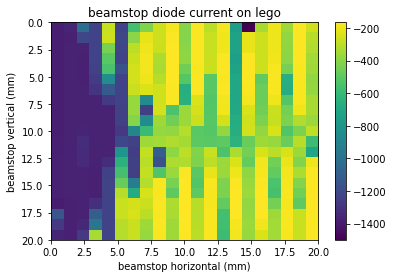

In [59]:
header = db[-1]
a = header.table()

# horizontal axis is reverted somehow (14,6 is optimal) 

h = a['sample stage horizontal'].to_numpy()
v = a['sample stage vertical'].to_numpy()
b = a['beamstop diode'].to_numpy()
b = b.reshape(21, 21)
b[b<-1500] = -1500

plt.imshow(b.T, extent=(h.min(), h.max(), v.max(), v.min()), aspect='auto')
plt.xlabel('beamstop horizontal (mm)')
plt.ylabel('beamstop vertical (mm)')
plt.title('beamstop diode current on lego')
plt.colorbar()
plt.show()

In [66]:
header = db[-2]
header.table()

,time,beamstop diode,sample stage horizontal,sample stage horizontal_user_setpoint,sample stage vertical,sample stage vertical_user_setpoint
seq_num,,,,,,
1,2025-06-25 21:27:14.344913721,-1390.20,0.0,0.0,0.0,0.0
2,2025-06-25 21:27:16.415581942,-1390.40,0.0,0.0,1.0,1.0
3,2025-06-25 21:27:18.487317562,-1390.30,0.0,0.0,2.0,2.0
4,2025-06-25 21:27:20.555586815,-1390.40,0.0,0.0,3.0,3.0
5,2025-06-25 21:27:22.644182205,-1389.80,0.0,0.0,4.0,4.0
...,...,...,...,...,...,...
437,2025-06-25 21:42:20.751756430,-171.90,20.0,20.0,16.0,16.0
438,2025-06-25 21:42:22.840008974,-173.50,20.0,20.0,17.0,17.0
439,2025-06-25 21:42:24.923892021,-171.56,20.0,20.0,18.0,18.0


In [60]:
# 25-06-25 3 pm
# Change diode filter to 32

RE(grid_scan([beamstop_diode], sample_x_mm, 0, 20, 21, sample_y_mm, 0, 20 ,21,snake_axes=True))

('7b56871f-6c87-4d8b-8479-5bafb6871933',)

In [63]:
header = db[-1]
a = header.table()
a

,time,beamstop diode,sample stage horizontal,sample stage horizontal_user_setpoint,sample stage vertical,sample stage vertical_user_setpoint
seq_num,,,,,,
1,2025-06-25 22:03:23.040972710,-165.91,0.0,0.0,0.0,0.0
2,2025-06-25 22:03:25.118822575,-165.99,0.0,0.0,1.0,1.0
3,2025-06-25 22:03:27.206385612,-165.88,0.0,0.0,2.0,2.0
4,2025-06-25 22:03:29.294667006,-165.63,0.0,0.0,3.0,3.0
5,2025-06-25 22:03:31.380166054,-165.14,0.0,0.0,4.0,4.0
...,...,...,...,...,...,...
437,2025-06-25 22:18:29.760398149,-166.47,20.0,20.0,16.0,16.0
438,2025-06-25 22:18:31.834867001,-166.38,20.0,20.0,17.0,17.0
439,2025-06-25 22:18:33.906876087,-166.26,20.0,20.0,18.0,18.0


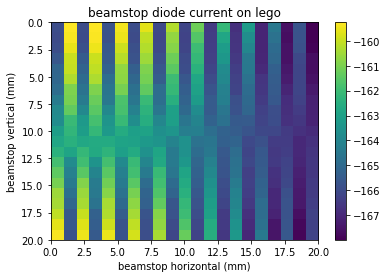

In [65]:
# horizontal axis is reverted somehow (14,6 is optimal) 

h = a['sample stage horizontal'].to_numpy()
v = a['sample stage vertical'].to_numpy()
b = a['beamstop diode'].to_numpy()
b = b.reshape(21, 21)
# b[b<-1500] = -1500

plt.imshow(b.T, extent=(h.min(), h.max(), v.max(), v.min()), aspect='auto')     # transpose to get the right orientation
plt.xlabel('beamstop horizontal (mm)')
plt.ylabel('beamstop vertical (mm)')
plt.title('beamstop diode current on lego')
plt.colorbar()
plt.show()


In [71]:
# worse result. 
# There are intricacies with the diode filter that I dont understand yet: setting number is not the same as the caget one. 
#   It was set to 32, but caget shows 26. 
# From documentation: Higher values result in more accuracy but a longer stability time. 
# Changed the filter to 16 --> 14

RE(grid_scan([beamstop_diode], sample_x_mm, 0, 20, 21, sample_y_mm, 0, 20 ,21, snake_axes=True))

('c83c88c5-7b86-412f-99ed-f596e0b115b4',)

In [72]:
header = db[-1]
a = header.table()
a

,time,beamstop diode,sample stage horizontal,sample stage horizontal_user_setpoint,sample stage vertical,sample stage vertical_user_setpoint
seq_num,,,,,,
1,2025-06-25 23:09:43.072465897,-1416.7,0.0,0.0,0.0,0.0
2,2025-06-25 23:09:45.148850679,-1417.1,0.0,0.0,1.0,1.0
3,2025-06-25 23:09:47.240825415,-1415.6,0.0,0.0,2.0,2.0
4,2025-06-25 23:09:49.311502695,-1415.6,0.0,0.0,3.0,3.0
5,2025-06-25 23:09:51.393030167,-1415.0,0.0,0.0,4.0,4.0
...,...,...,...,...,...,...
437,2025-06-25 23:24:49.601794720,-497.6,20.0,20.0,16.0,16.0
438,2025-06-25 23:24:51.683125257,-591.4,20.0,20.0,17.0,17.0
439,2025-06-25 23:24:53.752349377,-614.9,20.0,20.0,18.0,18.0


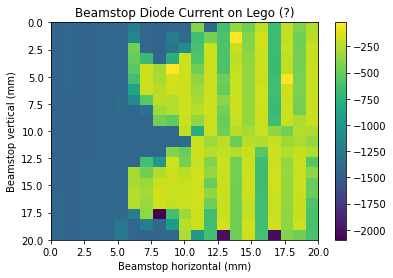

In [75]:
h = a['sample stage horizontal'].to_numpy()
v = a['sample stage vertical'].to_numpy()
b = a['beamstop diode'].to_numpy()
b = b.reshape(21, 21)

plt.imshow(b.T, extent=(h.min(), h.max(), v.max(), v.min()), aspect='auto')     # transpose to get the right orientation
plt.xlabel('Beamstop horizontal (mm)')
plt.ylabel('Beamstop vertical (mm)')
plt.title('Beamstop Diode Current on Lego (?)')
plt.colorbar()
plt.show()

In [74]:
# Good result. Better resolution now. 
# At sample (x=0, y=0), align the beamstop to (13.5, 7.5) mm. 

RE(grid_scan([beamstop_diode], sample_x_mm, 3, 15, 25, sample_y_mm, 0, 20 ,41, snake_axes=True))

('90688e6d-8560-4a68-8e8b-8f8daf6df9f9',)

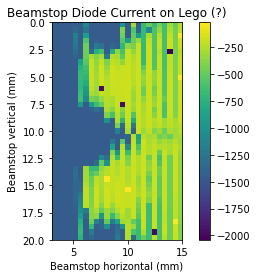

In [77]:
header = db[-1]
a = header.table()

h = a['sample stage horizontal'].to_numpy()
v = a['sample stage vertical'].to_numpy()
b = a['beamstop diode'].to_numpy()
b = b.reshape(25, 41)

# plt.figure(figsize)

plt.imshow(b.T, extent=(h.min(), h.max(), v.max(), v.min()), aspect='equal')     # transpose to get the right orientation
plt.xlabel('Beamstop horizontal (mm)')
plt.ylabel('Beamstop vertical (mm)')
plt.title('Beamstop Diode Current on Lego (?)')
plt.colorbar()
plt.show()

## Spectroscopic scan

In [78]:

#physical constants
h_m2kgps = 6.6261e-34
c_mps    = 299792458   
e_eV     = 6.2415e+18
# Silicon spacing (for Bragg condition)
Si_m = 5.43E-10
a_Si111_m = Si_m/np.sqrt(1^2+1^2+1^2)
# Monochromotor offset
mono_offset_deg = 12.787
# Wavelength from energy
lambda_m = lambda E_eV : h_m2kgps*c_mps*e_eV/E_eV
# Bragg angle from Wavelength
bragg_deg = lambda E_eV: np.arcsin(lambda_m(E_eV)/(2*a_Si111_m))*180/np.pi
# Mono angle from Bragg angle
mono_deg = lambda E_eV: bragg_deg(E_eV)+mono_offset_deg

# inverse function to go from mono angle to eV
energy_eV = lambda mono_deg_input: (h_m2kgps*c_mps*e_eV)/((2 * a_Si111_m) * np.sin((np.pi/180)*(mono_deg_input - mono_offset_deg)))


In [79]:
# print current energy

current_mono = epics.caget('bl531_xps1:mono_angle_deg')

current_energy = np.round(energy_eV(current_mono), 1)
print(f'Current energy: {current_energy} eV')

Current energy: 9347.4 eV


In [81]:
from time import sleep as time_sleep

# set a new energy 

new_energy = 8800

new_mono = mono_deg(new_energy)
epics.caput('bl531_xps1:mono_angle_deg', new_mono)
time_sleep(5)

# print new energy
new_mono = epics.caget('bl531_xps1:mono_angle_deg')
new_energy = np.round(energy_eV(new_mono), 1)
print(f'New energy: {new_energy} eV')


New energy: 8800.0 eV


In [82]:
E_eV_start = 8000 # start energy in eV
E_eV_stop = 10000 # start energy in eV
N_e = 41  # number of energy points

Es_eV = np.linspace(E_eV_start, E_eV_stop, N_e)
thetas_deg = mono_deg(Es_eV)

mono_angle_deg.settle_time = 0.5

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg))

('0a9a8262-fe53-48c7-a449-c19fa4112e60',)

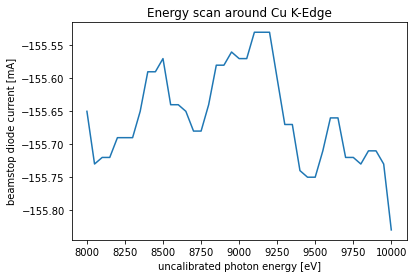

In [83]:
%matplotlib inline

a = db[-1].table()
import matplotlib.pyplot as plt

t = a['mono angle [deg]'].to_numpy()

d = a['beamstop diode'].to_numpy()

plt.plot(energy_eV(t), d)
plt.title('Energy scan around Cu K-Edge')
plt.xlabel('uncalibrated photon energy [eV]')
plt.ylabel('beamstop diode current [mA]')

plt.show()

In [105]:
# set a new energy 

new_energy = 8800

new_mono = mono_deg(new_energy)
epics.caput('bl531_xps1:mono_angle_deg', new_mono)
time_sleep(5)

# print new energy
new_mono = epics.caget('bl531_xps1:mono_angle_deg')
new_energy = np.round(energy_eV(new_mono), 1)
print(f'New energy: {new_energy} eV')

New energy: 8800.0 eV


In [85]:
E_eV_start = 8000 # start energy in eV
E_eV_stop = 10000 # start energy in eV
N_e = 41  # number of energy points

Es_eV = np.linspace(E_eV_start, E_eV_stop, N_e)
thetas_deg = mono_deg(Es_eV)

# mono_angle_deg.settle_time = 0.5

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg))

('6832523c-2bb6-4adf-9037-a5b0b744f180',)

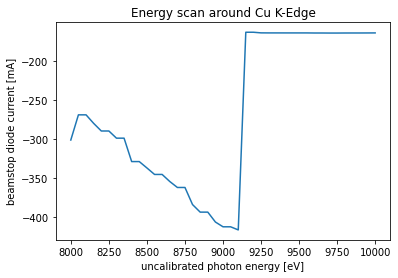

In [86]:
%matplotlib inline

a = db[-1].table()

t = a['mono angle [deg]'].to_numpy()
d = a['beamstop diode'].to_numpy()

plt.plot(energy_eV(t), d)
plt.title('Energy scan around Cu K-Edge')
plt.xlabel('uncalibrated photon energy [eV]')
plt.ylabel('beamstop diode current [mA]')

plt.show()

In [87]:
# Increasing the resolution of the scan

E_eV_start = 8500 # start energy in eV
E_eV_stop = 9500 # start energy in eV
N_e = 51  # number of energy points

Es_eV = np.linspace(E_eV_start, E_eV_stop, N_e)
thetas_deg = mono_deg(Es_eV)

# mono_angle_deg.settle_time = 0.5

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg))

('7fd08d4e-7a50-4c35-94f6-e75b08f32d66',)

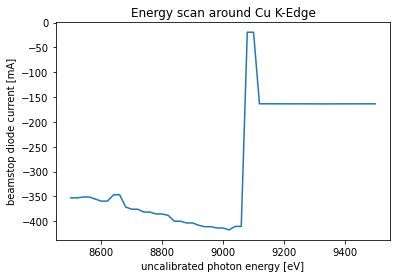

In [88]:
%matplotlib inline

a = db[-1].table()

t = a['mono angle [deg]'].to_numpy()
d = a['beamstop diode'].to_numpy()

plt.plot(energy_eV(t), d)
plt.title('Energy scan around Cu K-Edge')
plt.xlabel('uncalibrated photon energy [eV]')
plt.ylabel('beamstop diode current [mA]')

plt.show()

In [89]:
# Direct beam

E_eV_start = 8900 # start energy in eV
E_eV_stop = 9200 # start energy in eV
N_e = 121  # number of energy points

Es_eV = np.linspace(E_eV_start, E_eV_stop, N_e)
thetas_deg = mono_deg(Es_eV)

# mono_angle_deg.settle_time = 0.5

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg))

('8d66c300-4472-4849-80f4-e3522032dd15',)

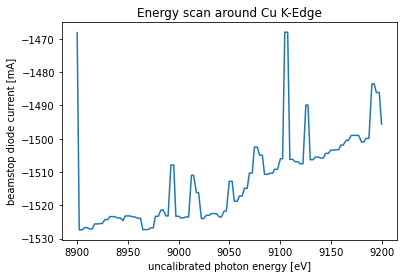

In [92]:
a = db[-1].table()

t = a['mono angle [deg]'].to_numpy()
d_direct = a['beamstop diode'].to_numpy()

plt.plot(energy_eV(t), d_direct)
plt.title('Energy scan around Cu K-Edge')
plt.xlabel('uncalibrated photon energy [eV]')
plt.ylabel('beamstop diode current [mA]')

plt.show()

In [93]:
# With copper foil

E_eV_start = 8900 # start energy in eV
E_eV_stop = 9200 # start energy in eV
N_e = 121  # number of energy points

Es_eV = np.linspace(E_eV_start, E_eV_stop, N_e)
thetas_deg = mono_deg(Es_eV)

# mono_angle_deg.settle_time = 0.5

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg))

('69db4c62-a70f-47ec-a704-dc088b47e684',)

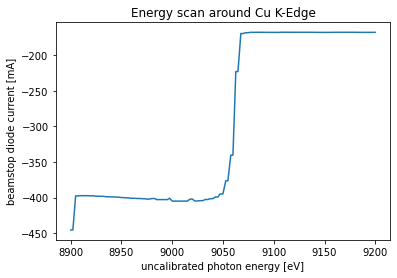

In [94]:
a = db[-1].table()

t = a['mono angle [deg]'].to_numpy()
d_copper = a['beamstop diode'].to_numpy()

plt.plot(energy_eV(t), d_copper)
plt.title('Energy scan around Cu K-Edge')
plt.xlabel('uncalibrated photon energy [eV]')
plt.ylabel('beamstop diode current [mA]')

plt.show()

Text(0, 0.5, 'beamstop diode current [mA]')

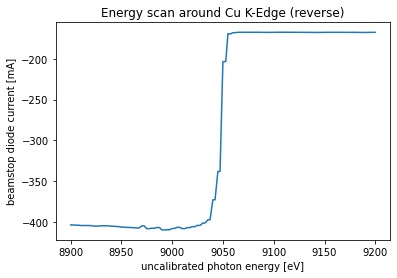

In [ ]:
# With copper foil

E_eV_start = 9200 # start energy in eV
E_eV_stop = 8900 # start energy in eV
N_e = 121  # number of energy points

Es_eV = np.linspace(E_eV_start, E_eV_stop, N_e)
thetas_deg = mono_deg(Es_eV)

# mono_angle_deg.settle_time = 0.5

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg))

a = db[-1].table()

t = a['mono angle [deg]'].to_numpy()
d_copper_reverse = a['beamstop diode'].to_numpy()

plt.plot(energy_eV(t), d_copper_reverse)
plt.title('Energy scan around Cu K-Edge (reverse)')
plt.xlabel('uncalibrated photon energy [eV]')
plt.ylabel('beamstop diode current [mA]')

In [98]:
d_copper

array([-445.5 , -445.5 , -397.7 , -397.7 , -397.4 , -397.4 , -397.4 ,
       -397.4 , -397.6 , -397.6 , -398.1 , -398.1 , -398.3 , -398.3 ,
       -398.9 , -398.9 , -399.1 , -399.1 , -399.5 , -399.5 , -400.1 ,
       -400.1 , -400.5 , -400.5 , -401.  , -401.  , -401.3 , -401.3 ,
       -401.6 , -401.6 , -402.2 , -402.2 , -401.4 , -401.4 , -402.9 ,
       -402.9 , -402.9 , -402.9 , -402.9 , -401.  , -405.  , -405.  ,
       -405.  , -405.1 , -405.  , -405.  , -405.  , -402.2 , -402.2 ,
       -404.9 , -404.9 , -404.4 , -404.4 , -402.8 , -402.8 , -401.6 ,
       -401.6 , -399.3 , -399.3 , -395.  , -395.  , -376.5 , -376.5 ,
       -340.4 , -340.4 , -223.  , -223.  , -169.56, -169.56, -168.37,
       -168.37, -167.84, -167.84, -167.84, -167.84, -167.82, -167.82,
       -167.89, -167.89, -167.94, -167.94, -167.94, -167.94, -167.74,
       -167.74, -167.76, -167.76, -167.78, -167.78, -167.8 , -167.8 ,
       -167.81, -167.81, -167.78, -167.78, -167.83, -167.83, -167.91,
       -167.91, -167

In [101]:
d_copper_flipped = d_copper[::-1]
d_copper_flipped.shape

(121,)

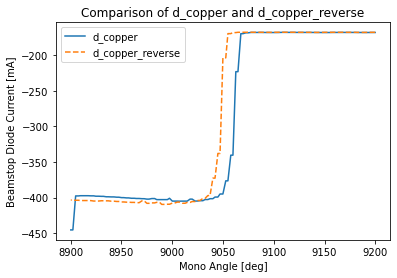

In [102]:
plt.plot(energy_eV(t), d_copper_flipped, label='d_copper')
plt.plot(energy_eV(t), d_copper_reverse, label='d_copper_reverse', linestyle='--')
plt.title('Comparison of d_copper and d_copper_reverse')
plt.xlabel('Mono Angle [deg]')
plt.ylabel('Beamstop Diode Current [mA]')
plt.legend()
plt.show()

In [103]:
# Forward again

E_eV_start = 8900 # start energy in eV
E_eV_stop = 9200 # start energy in eV
N_e = 121  # number of energy points

Es_eV = np.linspace(E_eV_start, E_eV_stop, N_e)
thetas_deg = mono_deg(Es_eV)

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg))

('d0f7a98d-f448-4877-8163-ae42aa097750',)

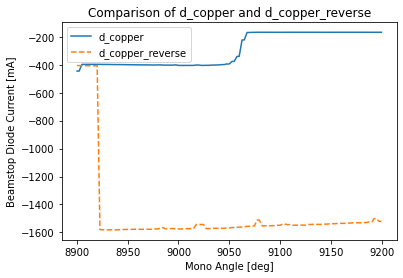

In [104]:
a = db[-1].table()

t = a['mono angle [deg]'].to_numpy()
d_copper_2 = a['beamstop diode'].to_numpy()

plt.plot(energy_eV(t), d_copper, label='d_copper')
plt.plot(energy_eV(t), d_copper_2, label='d_copper_reverse', linestyle='--')
plt.title('Comparison of d_copper and d_copper_reverse')
plt.xlabel('Mono Angle [deg]')
plt.ylabel('Beamstop Diode Current [mA]')
plt.legend()
plt.show()

In [106]:
# Foil felt off. Tried again. 

E_eV_start = 8900 # start energy in eV
E_eV_stop = 9200 # start energy in eV
N_e = 121  # number of energy points

Es_eV = np.linspace(E_eV_start, E_eV_stop, N_e)
thetas_deg_forward = mono_deg(Es_eV)
Es_eV_reverse = np.linspace(E_eV_stop, E_eV_start, N_e)
thetas_deg_reverse = mono_deg(Es_eV_reverse)

print(thetas_deg_forward)
print(thetas_deg_reverse)

[25.62421235 25.62054587 25.6168815  25.61321925 25.6095591  25.60590106
 25.60224513 25.5985913  25.59493956 25.59128993 25.5876424  25.58399696
 25.58035361 25.57671236 25.5730732  25.56943612 25.56580113 25.56216823
 25.55853741 25.55490867 25.55128201 25.54765742 25.54403492 25.54041448
 25.53679612 25.53317983 25.52956561 25.52595345 25.52234336 25.51873533
 25.51512936 25.51152546 25.50792361 25.50432381 25.50072608 25.49713039
 25.49353675 25.48994516 25.48635562 25.48276813 25.47918268 25.47559927
 25.4720179  25.46843857 25.46486128 25.46128602 25.45771279 25.4541416
 25.45057243 25.44700529 25.44344018 25.43987709 25.43631603 25.43275699
 25.42919996 25.42564495 25.42209196 25.41854099 25.41499202 25.41144507
 25.40790012 25.40435718 25.40081625 25.39727732 25.39374039 25.39020546
 25.38667253 25.3831416  25.37961266 25.37608572 25.37256077 25.3690378
 25.36551683 25.36199784 25.35848084 25.35496582 25.35145278 25.34794172
 25.34443264 25.34092554 25.33742041 25.33391726 25.3

In [107]:
# Compare consecutive forward and reverse scans

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg_forward))

a = db[-1].table()
t = a['mono angle [deg]'].to_numpy()
d_forward_1 = a['beamstop diode'].to_numpy()

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg))

a = db[-1].table()
t = a['mono angle [deg]'].to_numpy()
d_reverse = a['beamstop diode'].to_numpy()

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg_forward))

a = db[-1].table()
t = a['mono angle [deg]'].to_numpy()
d_forward_2 = a['beamstop diode'].to_numpy()

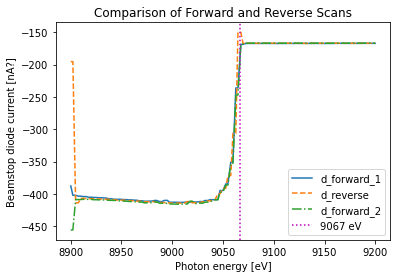

In [136]:
plt.plot(energy_eV(t), d_forward_1, label='d_forward_1')
plt.plot(energy_eV(t), d_reverse, label='d_reverse', linestyle='--')
plt.plot(energy_eV(t), d_forward_2, label='d_forward_2', linestyle='-.')
plt.title('Comparison of Forward and Reverse Scans')
plt.xlabel('Photon energy [eV]')
plt.ylabel('Beamstop diode current [nA?]')
plt.axvline(x=9067, color='m', linestyle=':', label='9067 eV')
plt.legend()
plt.show()

In [138]:
d_reverse[:20]

array([-195.5, -195.5, -413.8, -413.8, -407.1, -407.1, -407.2, -407.2,
       -407.5, -407.5, -408. , -408. , -408.1, -408.1, -408.4, -408.4,
       -408.9, -408.9, -409.7, -409.7])

In [ ]:
# Changed the filter to 32 again (reading 26)

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg_forward))

a = db[-1].table()
t = a['mono angle [deg]'].to_numpy()
d_forward_3 = a['beamstop diode'].to_numpy()

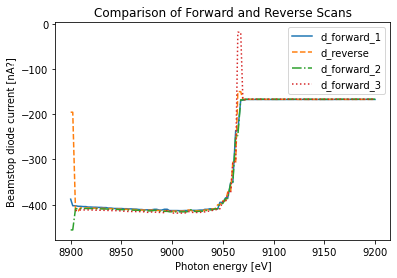

In [146]:
plt.plot(energy_eV(t), d_forward_1, label='d_forward_1')
plt.plot(energy_eV(t), d_reverse, label='d_reverse', linestyle='--')
plt.plot(energy_eV(t), d_forward_2, label='d_forward_2', linestyle='-.')
plt.plot(energy_eV(t)[2:], d_forward_3[2:], label='d_forward_3', linestyle=':')
plt.title('Comparison of Forward and Reverse Scans')
plt.xlabel('Photon energy [eV]')
plt.ylabel('Beamstop diode current [nA?]')
plt.legend()
plt.show()

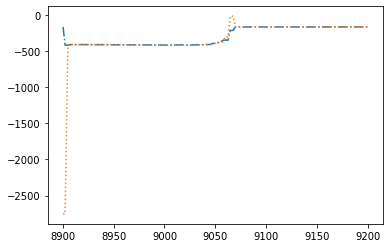

In [147]:
RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg_forward))

a = db[-1].table()
t = a['mono angle [deg]'].to_numpy()
d_forward_4 = a['beamstop diode'].to_numpy()

plt.plot(energy_eV(t), d_forward_4, label='d_forward_4', linestyle='-.')
plt.plot(energy_eV(t), d_forward_3, label='d_forward_3', linestyle=':')


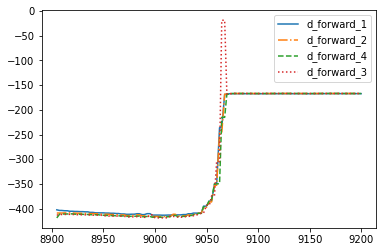

In [149]:
plt.plot(energy_eV(t)[2:], d_forward_1[2:], label='d_forward_1')
plt.plot(energy_eV(t)[2:], d_forward_2[2:], label='d_forward_2', linestyle='-.')
plt.plot(energy_eV(t)[2:], d_forward_4[2:], label='d_forward_4', linestyle='--')
plt.plot(energy_eV(t)[2:], d_forward_3[2:], label='d_forward_3', linestyle=':')
plt.legend()
plt.show()

In [154]:
d_forward_4

array([-166.9 , -418.7 , -418.7 , -411.  , -411.  , -410.7 , -410.7 ,
       -410.5 , -410.5 , -411.2 , -411.2 , -411.4 , -411.4 , -411.7 ,
       -411.7 , -412.2 , -412.2 , -412.3 , -412.3 , -413.2 , -413.2 ,
       -413.7 , -413.7 , -414.  , -414.  , -414.5 , -414.5 , -414.7 ,
       -414.7 , -415.5 , -415.5 , -415.4 , -415.4 , -415.  , -415.  ,
       -416.2 , -416.2 , -415.7 , -415.7 , -417.2 , -417.2 , -417.4 ,
       -417.4 , -417.3 , -417.3 , -416.1 , -416.1 , -413.6 , -413.6 ,
       -416.2 , -416.2 , -415.5 , -415.5 , -413.9 , -413.9 , -412.2 ,
       -412.2 , -409.4 , -409.4 , -396.2 , -396.2 , -382.4 , -382.4 ,
       -349.6 , -349.6 , -349.6 , -215.1 , -215.1 , -168.25, -168.25,
       -166.93, -166.93, -166.85, -166.85, -166.86, -166.86, -166.89,
       -166.89, -166.92, -166.92, -166.98, -166.98, -166.93, -166.93,
       -166.88, -166.88, -166.86, -166.86, -166.84, -166.84, -166.83,
       -166.83, -166.86, -166.86, -166.88, -166.88, -166.9 , -166.9 ,
       -166.92, -166

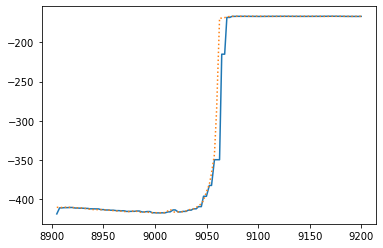

In [152]:
mono_angle_deg.settle_time = 1

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg_forward))

a = db[-1].table()
t = a['mono angle [deg]'].to_numpy()
d_forward_5 = a['beamstop diode'].to_numpy()

plt.plot(energy_eV(t)[2:], d_forward_4[2:], label='d_forward_4', linestyle='-')
plt.plot(energy_eV(t)[2:], d_forward_5[2:], label='d_forward_5', linestyle=':')

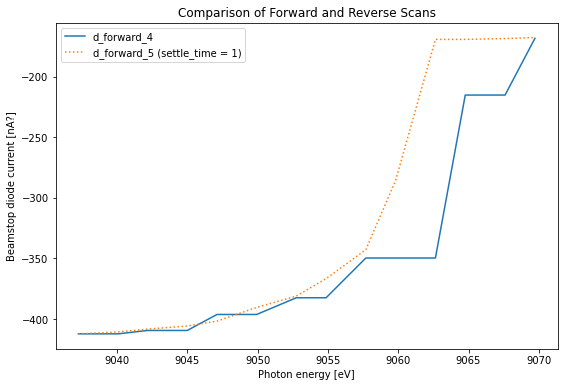

In [163]:
plt.figure(figsize=(9, 6))
plt.plot(energy_eV(t)[55:69], d_forward_4[55:69], label='d_forward_4', linestyle='-')
plt.plot(energy_eV(t)[55:69], d_forward_5[55:69], label='d_forward_5 (settle_time = 1)', linestyle=':')
plt.title('Comparison of Forward and Reverse Scans')
plt.xlabel('Photon energy [eV]')
plt.ylabel('Beamstop diode current [nA?]')
plt.legend()
plt.show()

In [164]:
mono_angle_deg.settle_time = 2

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg_forward))

a = db[-1].table()
t = a['mono angle [deg]'].to_numpy()
d_forward_6 = a['beamstop diode'].to_numpy()

mono_angle_deg.settle_time = 0.2

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg_forward))

a = db[-1].table()
t = a['mono angle [deg]'].to_numpy()
d_forward_7 = a['beamstop diode'].to_numpy()

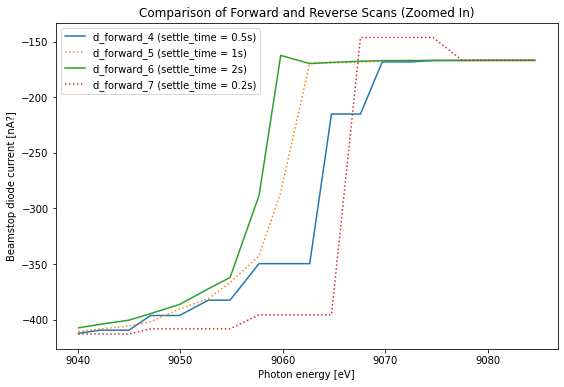

In [168]:
plt.figure(figsize=(9, 6))
plt.plot(energy_eV(t)[56:75], d_forward_4[56:75], label='d_forward_4 (settle_time = 0.5s)', linestyle='-')
plt.plot(energy_eV(t)[56:75], d_forward_5[56:75], label='d_forward_5 (settle_time = 1s)', linestyle=':')
plt.plot(energy_eV(t)[56:75], d_forward_6[56:75], label='d_forward_6 (settle_time = 2s)', linestyle='-')
plt.plot(energy_eV(t)[56:75], d_forward_7[56:75], label='d_forward_7 (settle_time = 0.2s)', linestyle=':')
plt.title('Comparison of Forward and Reverse Scans (Zoomed In)')
plt.xlabel('Photon energy [eV]')
plt.ylabel('Beamstop diode current [nA?]')
plt.legend()
plt.show()